In [94]:
from pyciemss import PetriNetODE


In [130]:
import os

from pyciemss.PetriNetODE.base import BetaNoisePetriNetODESystem
from pyciemss.PetriNetODE.interfaces import load_petri_model, setup_model, sample, calibrate
import pyciemss
import numpy as np

Let's see what directory we're in

In [119]:
os.getcwd()

'/home/chads/git/pyciemss/notebook'

Most of our files are relative to `test/models/`, so we need to go up a directory.

In [159]:
PYCIEMSS_PATH = ".."
STARTERKIT_PATH = os.path.join(PYCIEMSS_PATH, "test/models/starter_kit_examples/")
MIRA_PATH = os.path.join(PYCIEMSS_PATH, "test/models/evaluation_examples/")

filename = "CHIME-SIR/model_petri.json"
filename = os.path.join(STARTERKIT_PATH, filename)

model = BetaNoisePetriNetODESystem.from_mira(filename)

model = setup_model(model, start_time=0.0, start_state=dict(S=0.99, I=0.01, R=0.0))

In [218]:
def plot_sample(times, s, names, alpha=1):
    import matplotlib.pyplot as plt
    for i,name in enumerate(names):
        for trajectory in s[name]:
            plt.plot(times, trajectory, label=name, alpha=alpha, color='C' + str(i))

In [220]:
times = np.linspace(0.01, 30, 10)
num_samples = 100
data = sample(model, times, num_samples)

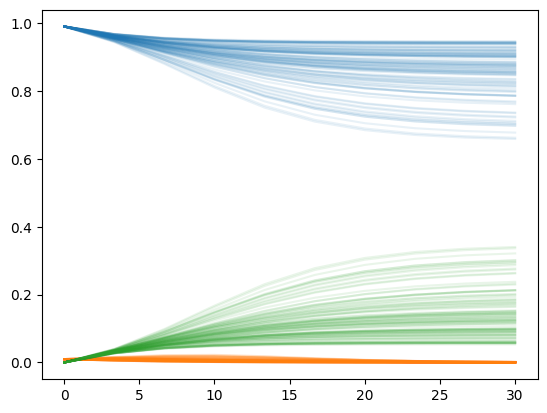

In [224]:
plot_sample(times, data, ('S_sol', 'I_sol', 'R_sol'), alpha=0.1)

In [225]:
obs = [(times[j], 
        {var: float(data[var + "_sol"][0,j]) for var in ["S", "I", "R"]})
    for j in range(0, len(times)) ]

In [193]:
obs[0]

(0.01,
 {'S': 0.9899020195007324,
  'I': 0.010002032853662968,
  'R': 9.596841846359894e-05})

In [194]:
post = calibrate(model, obs)
post

AutoNormal(
  (locs): PyroModule()
  (scales): PyroModule()
)

In [195]:
post_sample = sample(model, np.linspace(0.01, 30, 100), 20, inferred_parameters=post)
post_sample

{'a_beta': tensor([1.0940, 1.0970, 1.0773, 1.0611, 1.0935, 1.0828, 1.0961, 1.0977, 1.0893,
         1.0869, 1.0925, 1.0701, 1.0797, 1.0915, 1.0949, 1.0944, 1.0985, 1.0946,
         1.0939, 1.0976]),
 'a_gamma': tensor([0.9021, 0.9738, 0.9132, 0.9071, 0.9036, 0.9061, 0.9116, 0.9055, 0.9105,
         0.9070, 0.9030, 0.9159, 0.9109, 0.9046, 0.9025, 0.9111, 0.9044, 0.9063,
         0.9046, 0.9078]),
 'I_sol': tensor([[0.0100, 0.0106, 0.0112,  ..., 0.0014, 0.0013, 0.0012],
         [0.0100, 0.0104, 0.0107,  ..., 0.0013, 0.0012, 0.0012],
         [0.0100, 0.0105, 0.0110,  ..., 0.0015, 0.0014, 0.0013],
         ...,
         [0.0100, 0.0106, 0.0111,  ..., 0.0014, 0.0013, 0.0012],
         [0.0100, 0.0106, 0.0111,  ..., 0.0014, 0.0013, 0.0012],
         [0.0100, 0.0106, 0.0111,  ..., 0.0013, 0.0013, 0.0012]]),
 'R_sol': tensor([[9.0292e-05, 2.9039e-03, 5.8725e-03,  ..., 3.5494e-01, 3.5530e-01,
          3.5564e-01],
         [9.7434e-05, 3.1008e-03, 6.2046e-03,  ..., 2.6057e-01, 2.6094e-01,
  

In [6]:
# Show that inference works.

from pyro.infer.autoguide import AutoNormal
from pyro.poutine import block
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro

guide = AutoNormal(model)
optim = Adam({'lr': 0.03})
loss_f = Trace_ELBO(num_particles=1)
verbose = True

svi = SVI(model, guide, optim, loss=loss_f)

pyro.clear_param_store()

for j in range(100):
    # calculate the loss and take a gradient step
    # Passing a data argument to svi.step() will condition the model on the data.
    loss = svi.step()
    if verbose:
        if j % 25 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss))

[iteration 0001] loss: 22.7344
[iteration 0026] loss: 23.4423
[iteration 0051] loss: 20.6464
[iteration 0076] loss: 20.7368


In [7]:
# Remove the observation events
model.remove_observation_events()

In [8]:
# Load some static parameter intervention events
model.load_event(StaticParameterInterventionEvent(2.99, "beta", 0.0))
model.load_event(StaticParameterInterventionEvent(4.11, "beta", 10.))

# Load the logging events again
model.load_events(logging_events)

In [9]:
model._static_events

[StartEvent(time=0.0, initial_state={'S': tensor(0.9900), 'I': tensor(0.0100), 'R': tensor(0.)}),
 LoggingEvent(time=1),
 LoggingEvent(time=2),
 StaticParameterInterventionEvent(time=2.990000009536743, parameter=beta, value=0.0),
 LoggingEvent(time=3),
 LoggingEvent(time=4),
 StaticParameterInterventionEvent(time=4.110000133514404, parameter=beta, value=10.0),
 LoggingEvent(time=5),
 LoggingEvent(time=6),
 LoggingEvent(time=7),
 LoggingEvent(time=8),
 LoggingEvent(time=9)]

In [10]:
model._observation_var_names

[]

In [11]:
# use pyro predictive
from pyro.infer import Predictive

# Get the return value of model.
predictions = Predictive(model, guide=guide, num_samples=10)()

In [12]:
predictions

{'a_beta': tensor([1.0735, 1.0938, 1.0870, 1.0595, 1.0415, 1.0957, 1.0503, 1.0687, 1.0486,
         1.0633]),
 'a_gamma': tensor([0.9743, 0.9891, 0.9675, 0.9993, 0.9428, 0.9425, 0.9149, 0.9722, 1.0373,
         0.9123]),
 'I_sol': tensor([[0.0109, 0.0117, 0.0122, 0.0046, 0.6387, 0.2889, 0.1095, 0.0414, 0.0156],
         [0.0109, 0.0118, 0.0124, 0.0046, 0.6345, 0.2842, 0.1061, 0.0395, 0.0147],
         [0.0111, 0.0121, 0.0129, 0.0049, 0.6396, 0.2889, 0.1102, 0.0419, 0.0159],
         [0.0105, 0.0108, 0.0109, 0.0040, 0.6332, 0.2857, 0.1057, 0.0390, 0.0144],
         [0.0109, 0.0117, 0.0123, 0.0048, 0.6473, 0.2983, 0.1166, 0.0455, 0.0177],
         [0.0115, 0.0130, 0.0143, 0.0056, 0.6441, 0.2929, 0.1145, 0.0447, 0.0174],
         [0.0113, 0.0125, 0.0136, 0.0055, 0.6527, 0.3033, 0.1218, 0.0488, 0.0196],
         [0.0108, 0.0116, 0.0121, 0.0046, 0.6394, 0.2898, 0.1100, 0.0417, 0.0158],
         [0.0100, 0.0098, 0.0095, 0.0034, 0.6228, 0.2804, 0.0999, 0.0355, 0.0126],
         [0.0114, 0.012

In [13]:
model()

{'I': tensor([0.0090, 0.0081, 0.0072, 0.0026, 0.6279, 0.2985, 0.1096, 0.0401, 0.0146]),
 'R': tensor([0.0096, 0.0182, 0.0259, 0.0305, 0.2116, 0.7003, 0.8903, 0.9598, 0.9853]),
 'S': tensor([9.8138e-01, 9.7368e-01, 9.6691e-01, 9.6691e-01, 1.6056e-01, 1.2547e-03,
         1.9023e-04, 9.5335e-05, 7.4055e-05])}

In [ ]:
# SCAFFOLDING FOR DYNAMIC EVENT HANDLING BELOW

import pyro
from torch import Tensor
from torchdiffeq import odeint_event, odeint

Time = Tensor
State = tuple[Tensor, ...]

class BaseODEModel(pyro.nn.PyroModule):

    def __init__(self, static_events: list[Event]):
        super().__init__()
        # This is a list of events that are always sorted by time.
        # TODO: probably pre-sort this list just in case.
        self.static_events = static_events

    def deriv(self, t: Time, state: State) -> State:
        raise NotImplementedError

    @pyro.nn.pyro_method
    def param_prior(self):
        raise NotImplementedError

    @pyro.nn.pyro_method
    def initial_conditions_prior(self):
        raise NotImplementedError

    # @pyro.nn.pyro_method
    # def observation_model(self, state: State, tspan: Time, ?) -> ?: …

    def solve(self, initial_state: State, initial_time: Time) -> tuple[State, State]:
        
        current_state = initial_state
        current_time = initial_time

        solution = torch.tensor([])

        for i, static_event in enumerate(self.static_events):
            
            # TODO: change below
            # Note: Immediate goal is to get self.solve() to generate ode solutions that stop at the event times.
            # Note: Next we will add log likelihood at those events using an observation model.

            # Note: each static_event is an Event object, which has a forward() method that returns a Tensor.
            # TODO: Chad, could you please make this actually make sense.
            event_time, event_solution = odeint(self.deriv, current_state, current_time, event_fn=static_event)
    
            # TODO: Add log likelihood for event_solution.
            # Note: This will be done by adding an observation model to the ODE model and calling it with the event_solution as an argument.

            solution = torch.cat([solution, event_solution], dim=-1)
            # current = event_solution[-1]


    def forward(self, initial_state: State, initial_time: Time) -> tuple[State, State]:
        # Sample parameters from the prior. These parameters are generated as attributes of the model.
        self.param_prior()

        # TODO: Sample initial conditions from the prior instead of taking them as input.

        # Solve the ODE, taking into account any intervention and conditioning events.
        return self.solve(initial_state, initial_time)




In [ ]:
event_time, event_solution = odeint(self.deriv, current_state, current_time, event_fn=static_event)

In [ ]:

# TODO: Chad, initialize a stop event here.
# stop_event = ...

# TODO: Chad, create a model the subclasses BaseODEModel and has all of the above missing methods implemented.
# deriv, param_prior, initial_conditions_prior, observation_model
# class ActualODEModel(BaseODEModel):
#   ...

# TODO: Chad, instantiate the model here.
# model = ActualODEModel([stop_event])

# TODO: Chad, Call model.forward() here.
# solution, _ = model(initial_state, tspan)

In [7]:
observations = [ObservationEvent(torch.tensor([2.1]), {"I": torch.tensor([0.1])})]


In [8]:
conditioned_model = pyciemss.condition(model, observations)

AttributeError: module 'pyciemss' has no attribute 'condition'